In [1]:
import sys
sys.path.append("C:\\Users\\olgat\\Desktop\\Stage Amiens\\6_Github") 
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import mean_squared_error

In [2]:
model_2 = load_model('lstm_model.h5')
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            9720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 50)                1550      
Total params: 25,910
Trainable params: 25,910
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Face area markers
def list_to_array(input_list):
    np_list=[]
    for elem in input_list:
        df = pd.read_csv(elem, header=None).fillna(0)
        df = df.iloc[:,[ 40, 41, 42, 88, 89, 90, 91, 92, 83, 84, 85, 86, 87, 74, 75, 76, 77, 78, 79, 80, 81, 82, 72, 73, 67, # LEFT
                        45, 44, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 69, 65]]
#         df = df.iloc[:,[38, 40, 41,	42,	88,	89,	90,	91,	92,	83,	84,	85,	86,	87,	74,	75,	76,	77,	78,	79,	80,	81,	82,	72,	73,	67, # LEFT
#                         98,	45,	44,	43,	46,	47,	48,	49,	50,	51,	52,	53,	54,	55,	56,	57,	58,	59,	60,	61,	62,	63,	64,	68,	69,	65]]

        np_array = df.to_numpy()
        np_list.append(np.nan_to_num(np_array))
    return np_list

In [4]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps # trouver la fin de sequense
        if end_ix > len(sequences)-1: # vérifier si on est au-delà du dataset
            break            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :] # rassembler les parties d'entrée et de sortie
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(true_future, prediction, num_marker, num_marker_2 = None):
    plt.figure(figsize=(15, 10))
    num_out = len(true_future)
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(num_out), np.array(true_future[:, num_marker:num_marker+1]), 'b-',
           label='Real mvt. Left side')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction[:, num_marker:num_marker+1]), 'r',
                 label='Predicted mvt')
    #plt.ylim(0, 25)
    plt.ylim(0,1)
    plt.title(f'Marker {num_marker}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')        
    plt.legend(loc='upper right')
    if num_marker_2 is not None:
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(num_out), np.array(true_future[:, num_marker_2:num_marker_2+1]), 'b-',
               label='Real mvt. Right side')
        if prediction.any():
            plt.plot(np.arange(num_out), np.array(prediction[:, num_marker_2:num_marker_2+1]), 'r',
                     label='Predicted mvt')
    plt.ylim(0, 1)
    #plt.ylim(0, 25)
    plt.title(f'Marker {num_marker_2}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')    
    plt.legend(loc='upper right')
    plt.show()

In [6]:
# statistics for two sides of the face
def stat(data):
#     df_g = data.iloc[:,[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24,	25]] # Left
#     df_d = data.iloc[:,[26,	27,	28,	29,	30,	31,	32,	33,	34,	35,	36,	37,	38,	39,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	50,	51]] # Right
    df_g = data.iloc[:,[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24]] # Left   
    df_d = data.iloc[:,[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]] # Right

    df_stat_g = df_g.append([df_g.describe().iloc[[1,2],:]]) # mean rmse                             
    df_stat_d = df_d.append([df_d.describe().iloc[[1,2],:]]) # standard deviation for rmse
    return  df_stat_g, df_stat_d

In [7]:
def make_dataset(list_data, n_steps):
    feature_list =[]
    label_list = []
    for elem in list_data:
        feature, label = split_sequences(elem, n_steps)    
        feature_list.append(feature)
        label_list.append(label)
    feature_list  = np.array(feature_list)
    label_list = np.array(label_list)
    dataset = tf.data.Dataset.from_tensor_slices((feature_list, label_list))
    return dataset

### Test saine

In [8]:
path = "C:/Users/olgat/Desktop/Stage Amiens/4 - ML_MoCap/Mvt5/5MhrdP0_cup_M5"
dP0_csv = functions.list_of_files(path)
dP0_csv  = dP0_csv[int(len(dP0_csv)*0.7):] 

In [9]:
dP0_list = list_to_array(dP0_csv)
dP0_list = list_to_array(dP0_csv)
inter_list = functions.list_to_interpolate(dP0_list)
scaled_list, max_value_list, min_value_list = functions.scaled_data2(inter_list)

In [10]:
n_steps = 10
list_test = scaled_list
dataset_test = make_dataset(list_data = list_test, n_steps = n_steps)

In [11]:
score = model_2.evaluate(dataset_test, verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score[1]*100))

11/11 [==============================] - 1s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642
root_mean_squared_error: 6.42%


#### Test 0/1

In [12]:
def rmse(list_test, dataset_test, model):
    row = len(list_test)
    colum = list_test[0].shape[1]
    rmse_test = list()
    for x, y in dataset_test:
        rmse_m = np.zeros((1,colum))
        for i in range(y.numpy().shape[1]):
            rmse = round(mean_squared_error(y.numpy()[:,i], model.predict(x)[:,i], squared=False),5)
            rmse_m[:,i] = rmse
        rmse_test.append(rmse_m)
    newDF_01 = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(rmse_test)):
        newDF_01.iloc[i] = rmse_test[i]
    return newDF_01

In [13]:
newDF_01 = rmse(list_test, dataset_test, model_2)

In [14]:
df_stat_g, df_stat_d = stat(newDF_01)
mean_g= df_stat_g.iloc[-2].mean()
mean_d = df_stat_d.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
mean_g ,mean_d,dif_rel

(0.050896327272727256, 0.05773156363636362, 0.0068352363636363656)

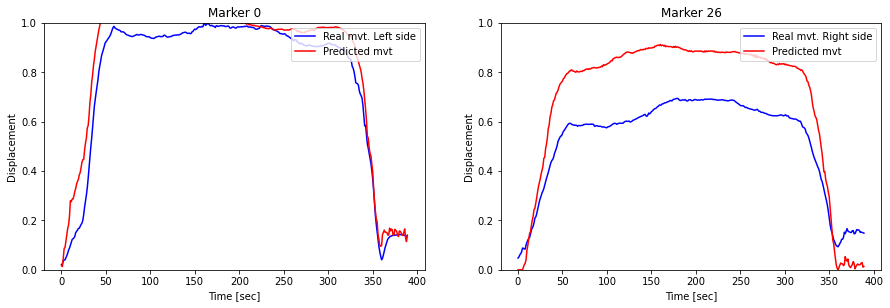

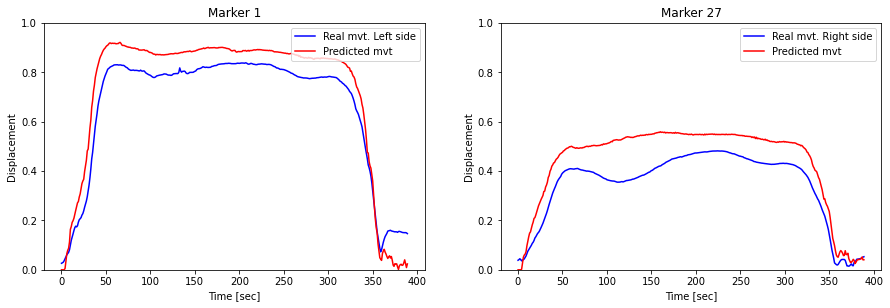

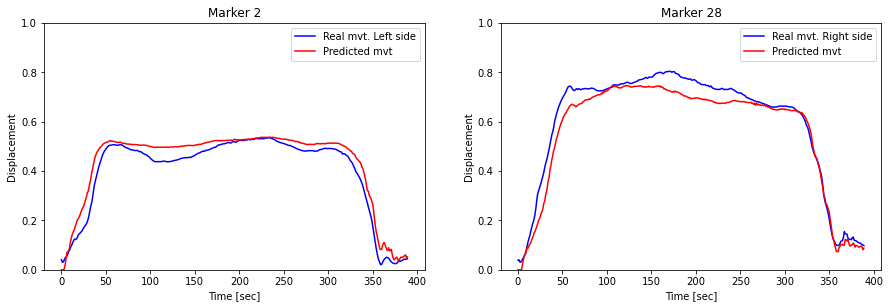

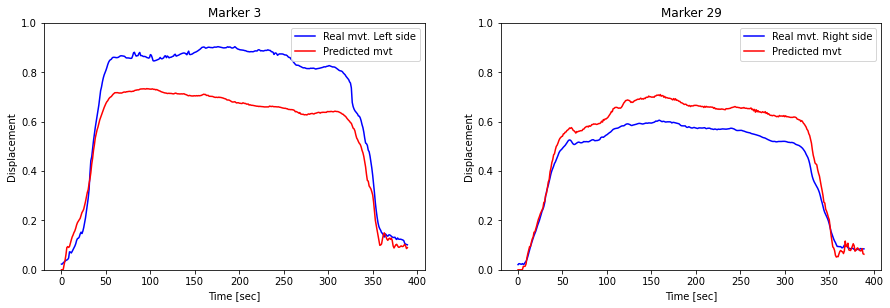

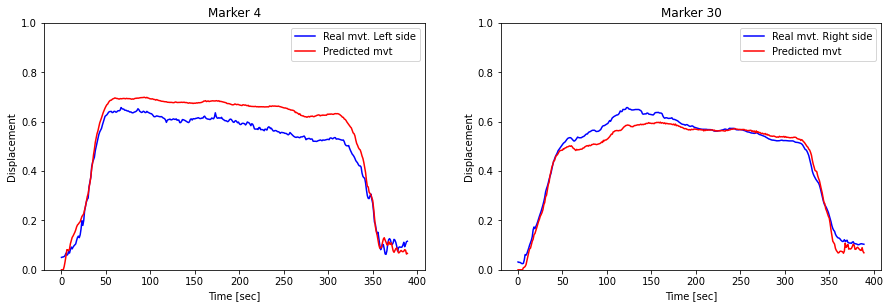

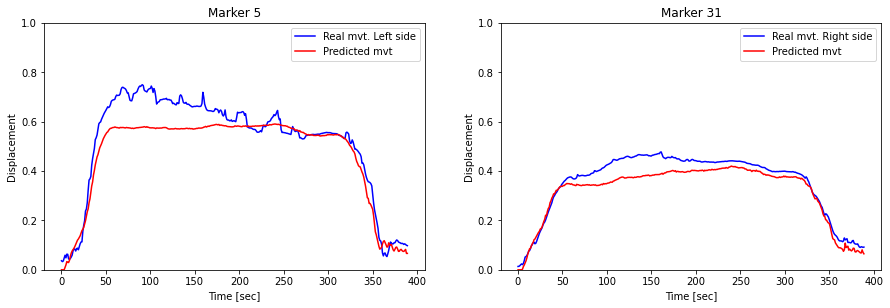

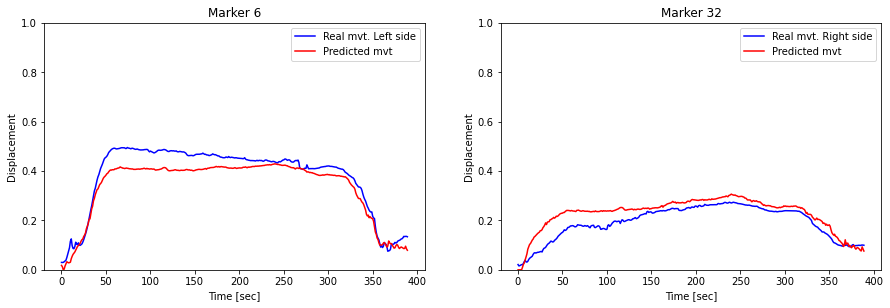

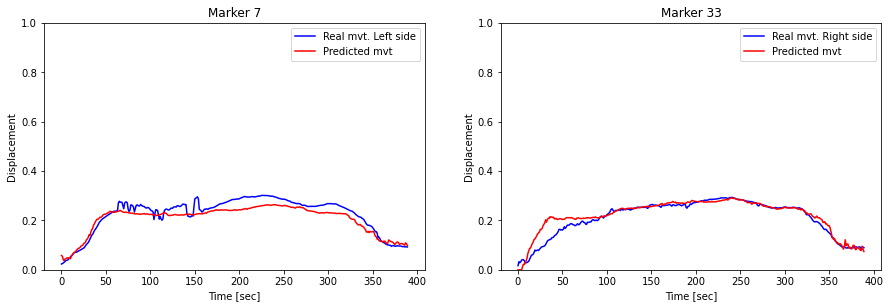

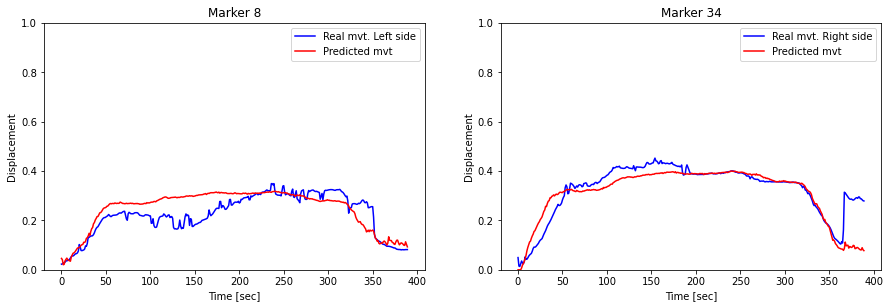

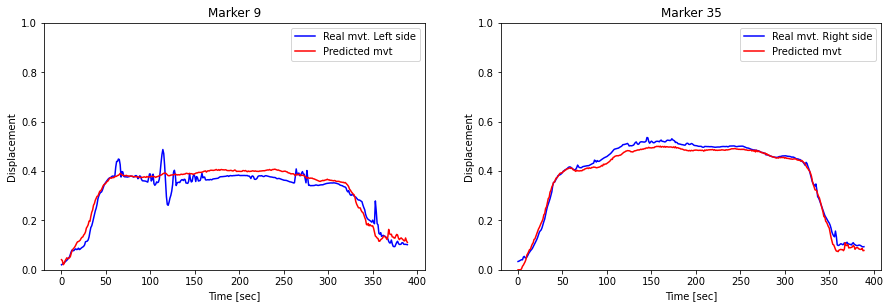

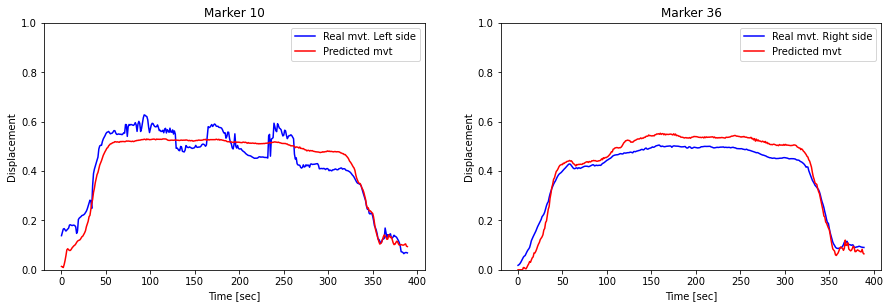

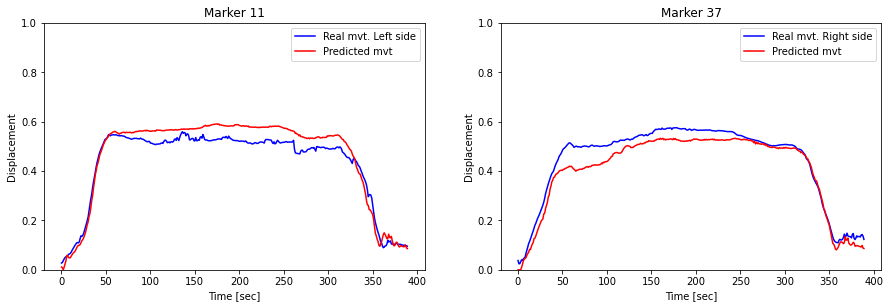

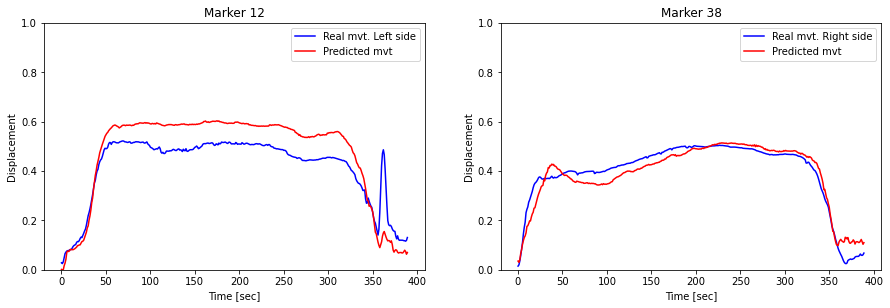

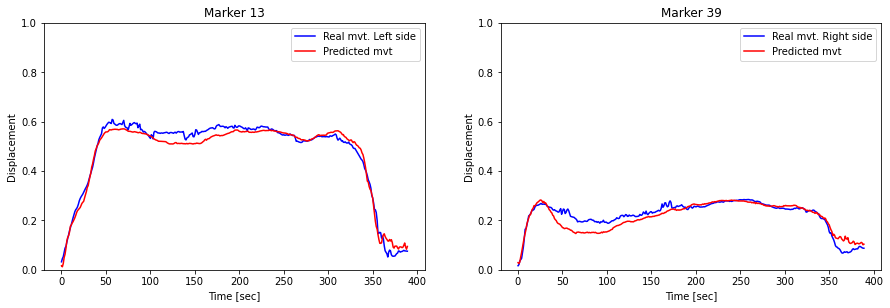

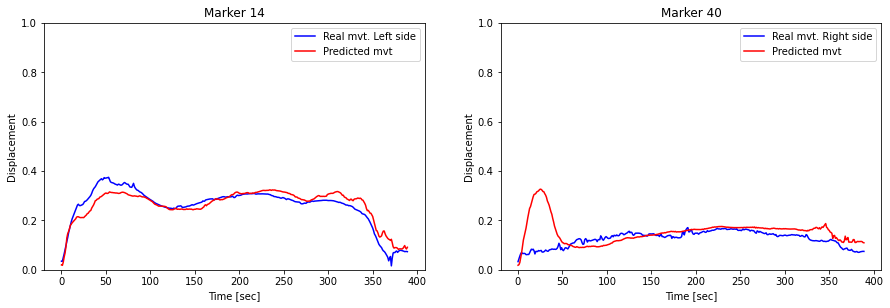

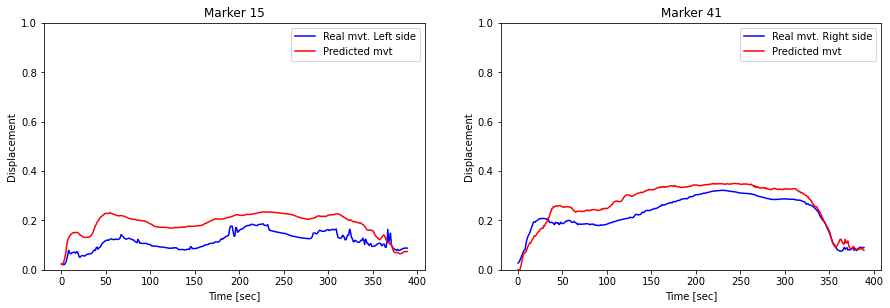

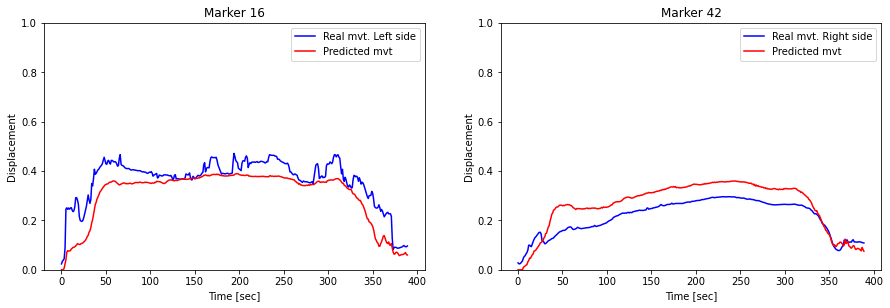

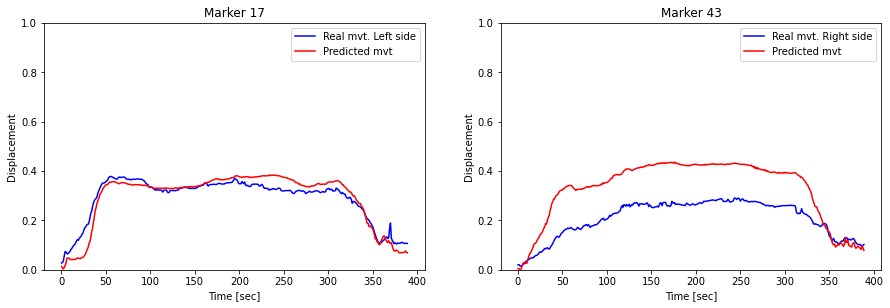

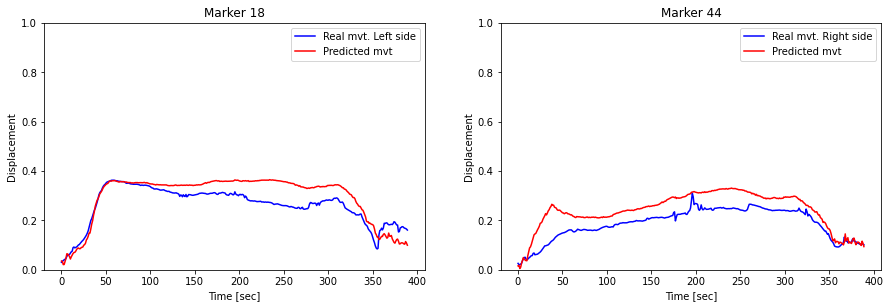

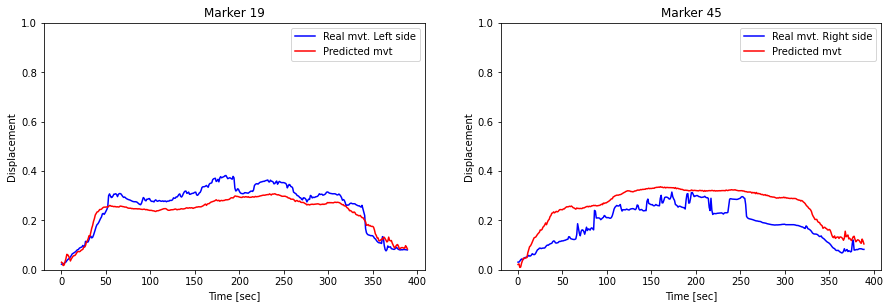

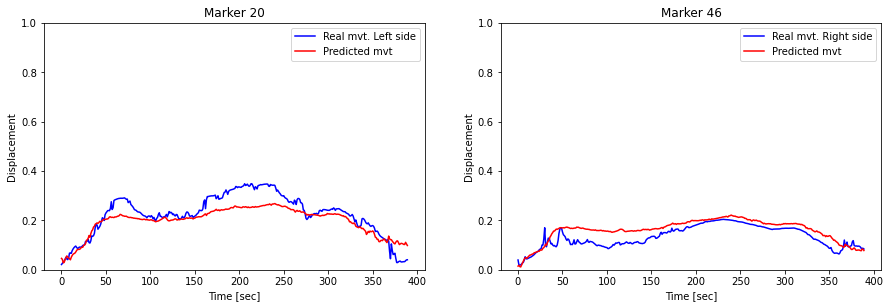

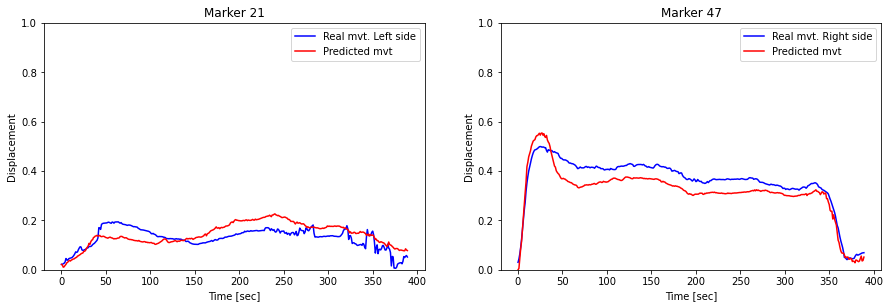

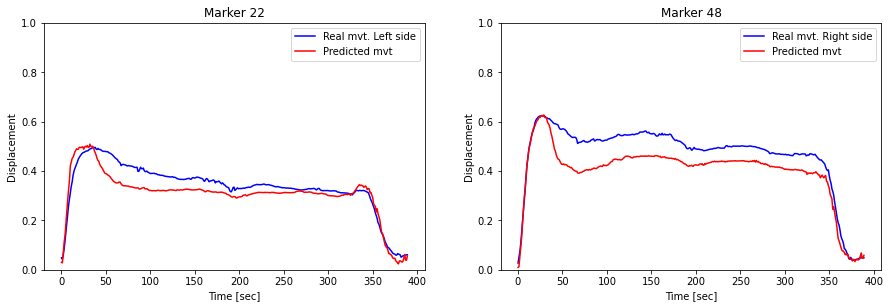

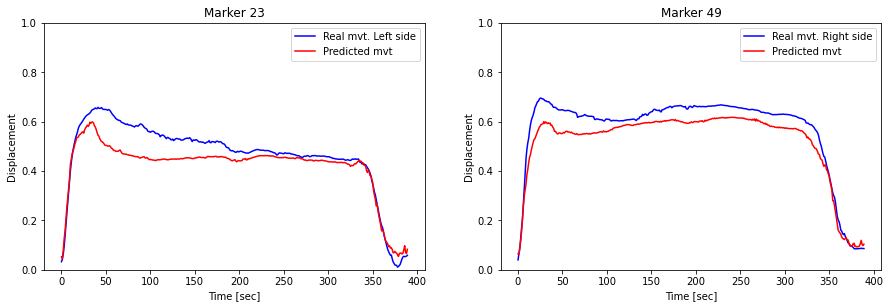

ZeroDivisionError: integer division or modulo by zero

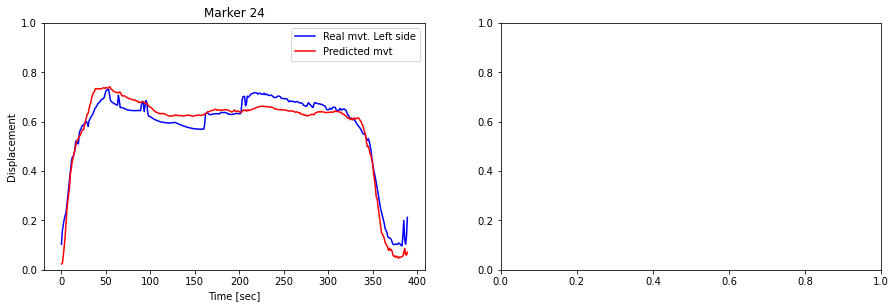

In [15]:
for x, y in dataset_test.take(1):
    for i in range(0,25):
        multi_step_plot(y,model_2.predict(x), i,i+26)

In [ ]:
# SAVE
#df_stat_g.to_excel('rmse_s_01_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_01_d.xlsx',header=None)

#### Test en mm

In [30]:
def rmse_mm(y_real, yhat):
    row = len(y_real)
    colum = y_real[0].shape[1]
    rmse_test = list()
    newDF = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(y_real)):
        rmse_m = np.zeros((1,colum))
        for j in range(colum):
            rmse = round(mean_squared_error(y_real[i][:,j], yhat[i][:,j], squared=False),5)
            rmse_m[:,j] = rmse
        rmse_test.append(rmse_m)
    for i in range(len(rmse_test)):
        newDF.iloc[i] = rmse_test[i]    
    return newDF

In [31]:
# initial data dimension (inverse scaled)
y_list, pred_list = list(), list()
for x, Y in dataset_test:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat = functions.list_invers_scaled(pred_list, max_value_list, min_value = 0)
y_real = functions.list_invers_scaled(y_list, max_value_list, min_value = 0)

In [32]:
newDF_mm = rmse_mm(y_real, yhat)
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g - mean_d)
mean_g, mean_d, dif_rel

(0.9146266181818181, 1.034248581818182, 0.11962196363636379)

In [ ]:
for i in range(len(y_real)):
    multi_step_plot(y_real[i], yhat[i], 1,27) 

In [ ]:
# SAVE
#df_stat_g.to_excel('rmse_s_mm_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_mm_d.xlsx',header=None)

### Test paralise

In [17]:
path = "C:/Users/olgat/Desktop/Stage Amiens/5 - MALADE/M5prdP0_cup"
dP0p_csv = functions.list_of_files(path, shuffle=False)
dP0p_csv=dP0p_csv[1:] # patient 1
#dP0p_csv=[dP0p_csv[0]] # patient 2
dP0p_csv

['C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\M5_01.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\M5_03.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\M5_04.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\M5_05.csv']

In [18]:
# Preposessing
dP0p_list = list_to_array(dP0p_csv)
inter_list_p = functions.list_to_interpolate(dP0p_list)
inter_list_p[0].shape, len(inter_list_p)
scaled_list_p, max_value_list_p, min_value_list_p = functions.scaled_data2(inter_list_p)

In [19]:
list_test_p = scaled_list_p
n_steps = 10
dataset_test_p = make_dataset(list_data = list_test_p, n_steps = n_steps)

In [20]:
score2 = model_2.evaluate(dataset_test_p , verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score2[1]*100))

4/4 [==============================] - 0s 7ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269
root_mean_squared_error: 12.69%


#### Test 0/1

In [21]:
newDF_01_p = rmse(list_test_p, dataset_test_p, model_2)

In [22]:
df_stat_g_p, df_stat_d_p = stat(newDF_01_p)
mean_g_p= df_stat_g_p.iloc[-2].mean()
mean_d_p = df_stat_d_p.iloc[-2].mean()
dif_rel_p = abs(mean_g_p-mean_d_p)
mean_g_p ,mean_d_p,dif_rel_p

(0.10154900000000001, 0.12266900000000001, 0.02112)

In [23]:
df_stat_g_p

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.204350,0.274990,0.101720,0.066440,0.074590,0.115650,0.070890,0.041600,0.082860,0.079690,...,0.146090,0.061500,0.077530,0.152300,0.170240,0.145580,0.166320,0.091440,0.099820,0.112000
1,0.149120,0.269830,0.086270,0.071020,0.044400,0.073060,0.047800,0.065040,0.102320,0.101670,...,0.198890,0.072750,0.103560,0.172130,0.178810,0.157670,0.176300,0.079460,0.102370,0.134210
2,0.217500,0.313630,0.089880,0.078740,0.084490,0.129980,0.096430,0.050790,0.077450,0.073540,...,0.137500,0.048760,0.055830,0.128330,0.146450,0.124180,0.146410,0.064670,0.083490,0.123420
3,0.185890,0.322720,0.090510,0.081110,0.074380,0.137590,0.113750,0.071130,0.059990,0.060090,...,0.122220,0.058970,0.046440,0.119100,0.124300,0.099520,0.119010,0.053870,0.068640,0.132270
mean,0.189215,0.295293,0.092095,0.074328,0.069465,0.114070,0.082217,0.057140,0.080655,0.078747,...,0.151175,0.060495,0.070840,0.142965,0.154950,0.131738,0.152010,0.072360,0.088580,0.125475
std,0.029708,0.026765,0.006683,0.006798,0.017363,0.028813,0.028920,0.013416,0.017431,0.017335,...,0.033307,0.009853,0.025404,0.023955,0.024595,0.025555,0.025266,0.016487,0.015706,0.010137


In [24]:
df_stat_d_p

,25,26,27,28,29,30,31,32,33,34,...,40,41,42,43,44,45,46,47,48,49
0,0.176750,0.047960,0.152450,0.160770,0.067070,0.066050,0.14102,0.198840,0.120670,0.201220,...,0.141260,0.059410,0.121580,0.202170,0.214840,0.280900,0.273950,0.128430,0.109420,0.169940
1,0.191030,0.108610,0.119840,0.093640,0.082840,0.075950,0.07590,0.130560,0.084490,0.143500,...,0.161870,0.070880,0.104900,0.163780,0.176040,0.238190,0.246120,0.124320,0.136130,0.168730
2,0.168040,0.036480,0.142990,0.167020,0.051720,0.046490,0.10445,0.153110,0.083800,0.164900,...,0.104700,0.049780,0.081950,0.156560,0.165120,0.238760,0.239320,0.089560,0.096190,0.193290
3,0.180320,0.063660,0.138830,0.134690,0.052000,0.053650,0.08699,0.125460,0.079270,0.155640,...,0.088340,0.063500,0.064420,0.143970,0.153720,0.228590,0.222790,0.085140,0.091100,0.168270
mean,0.179035,0.064177,0.138528,0.139030,0.063407,0.060535,0.10209,0.151993,0.092058,0.166315,...,0.124042,0.060892,0.093213,0.166620,0.177430,0.246610,0.245545,0.106862,0.108210,0.175058
std,0.009516,0.031647,0.013700,0.033342,0.014807,0.013073,0.02849,0.033463,0.019215,0.024865,...,0.033547,0.008798,0.025147,0.025074,0.026553,0.023331,0.021321,0.022665,0.020151,0.012175


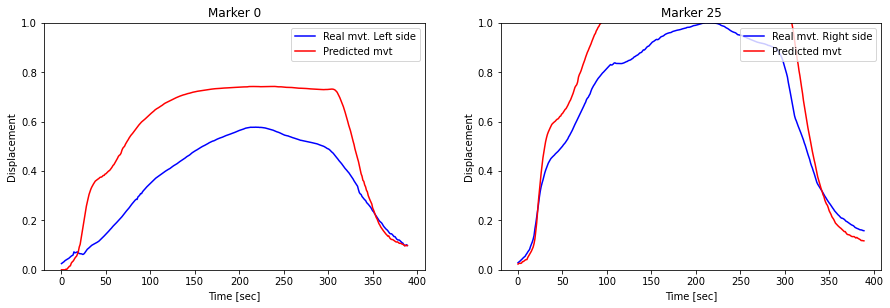

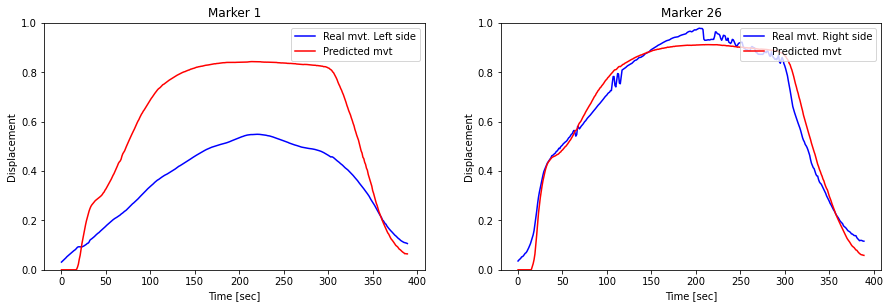

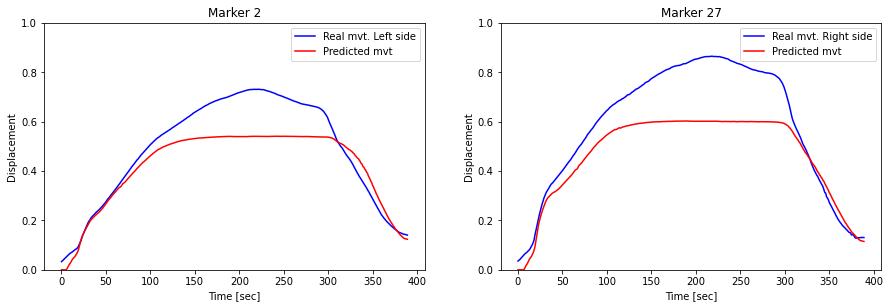

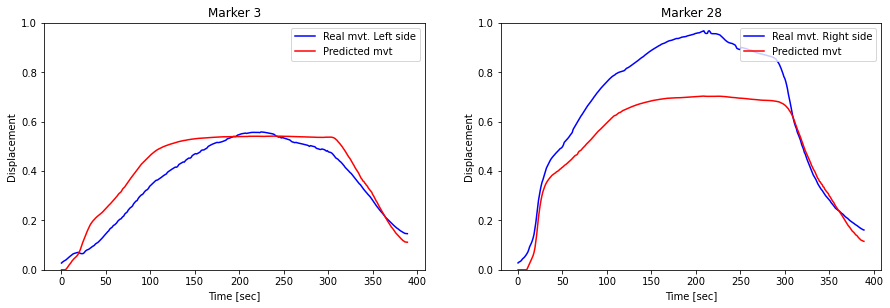

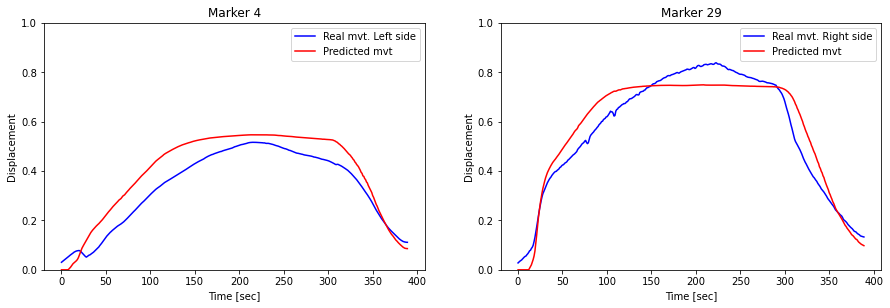

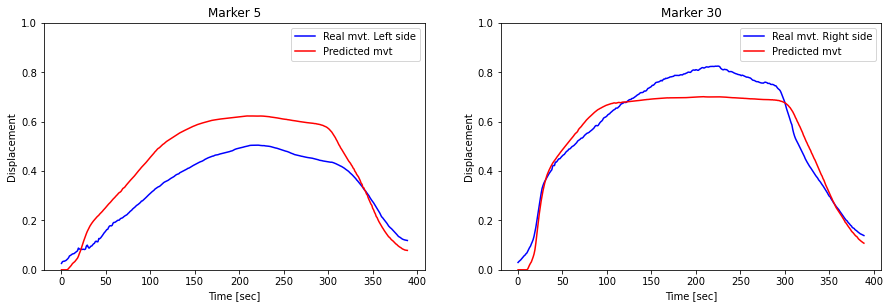

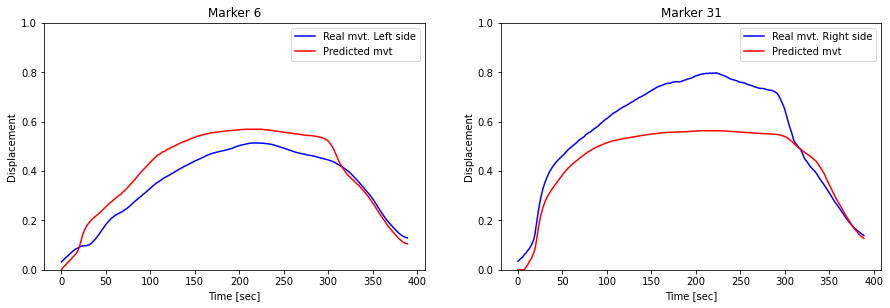

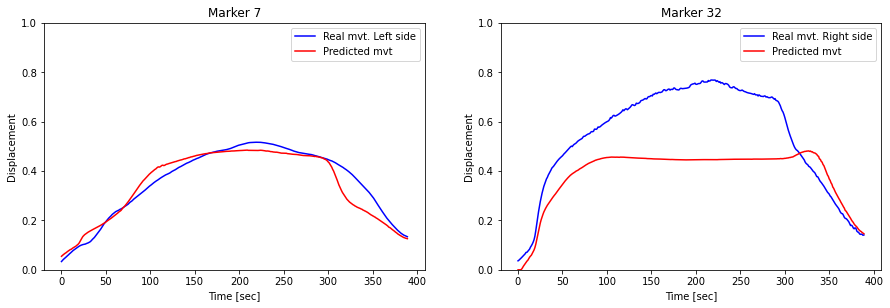

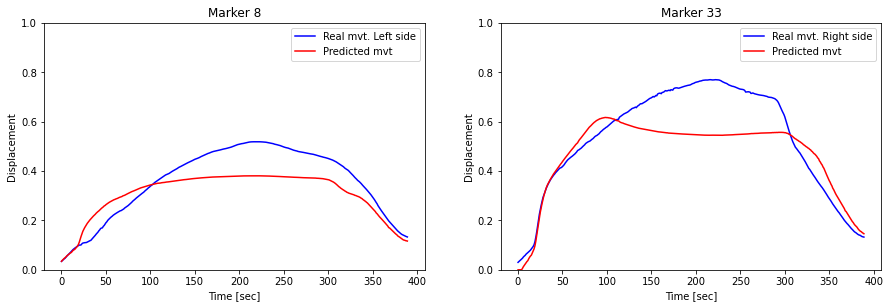

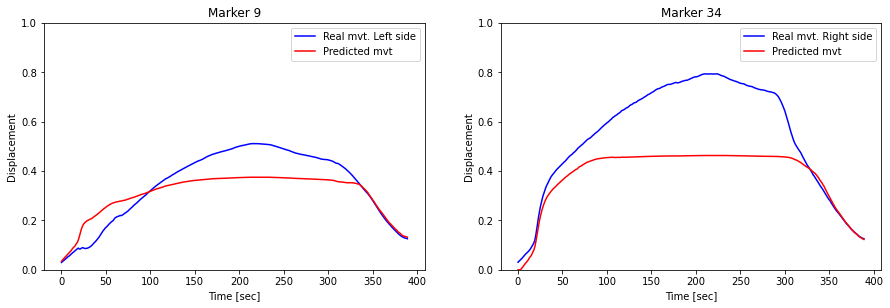

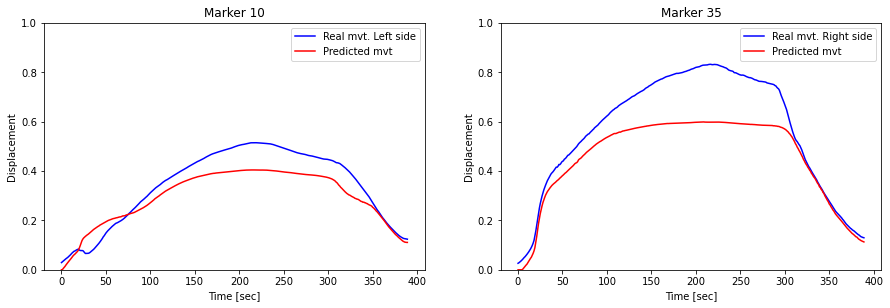

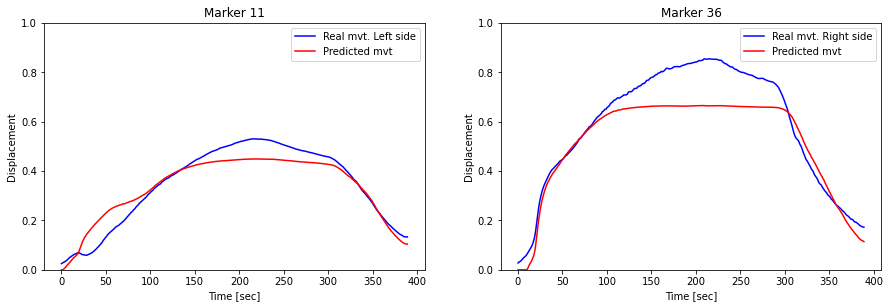

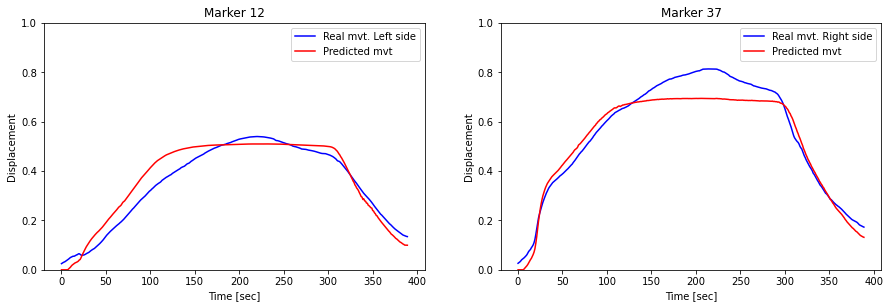

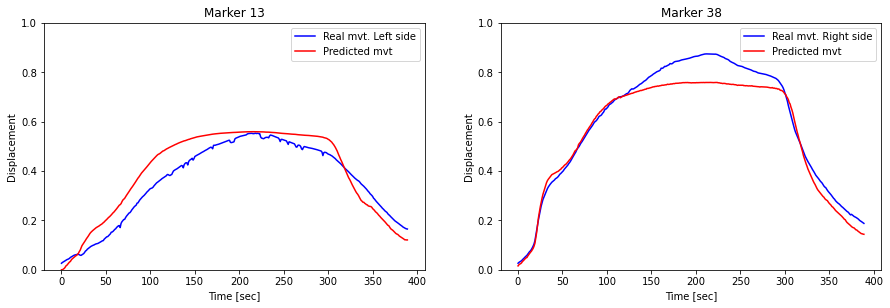

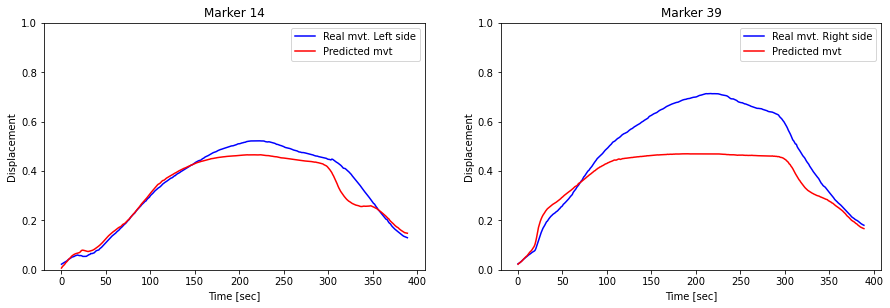

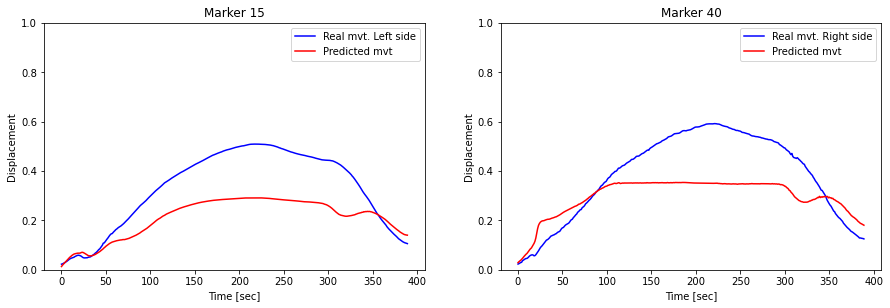

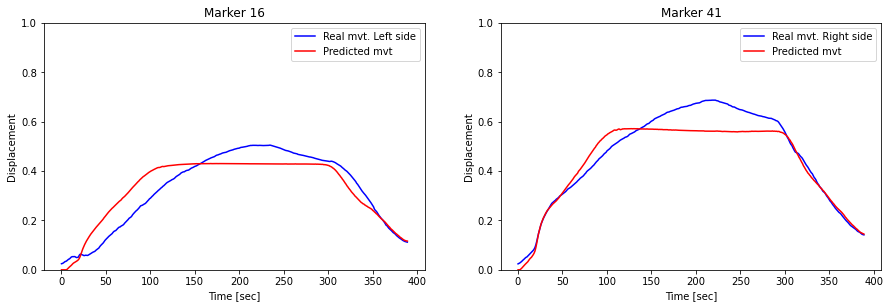

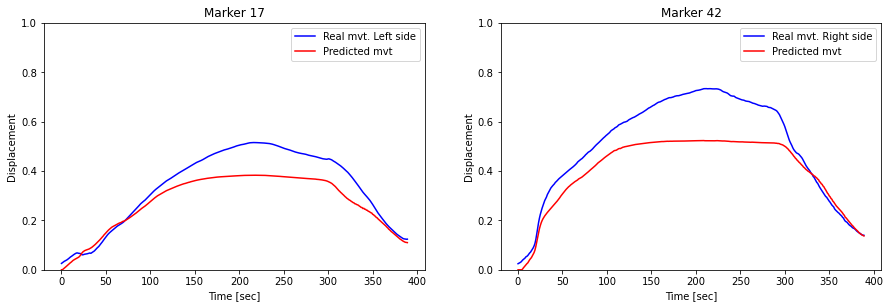

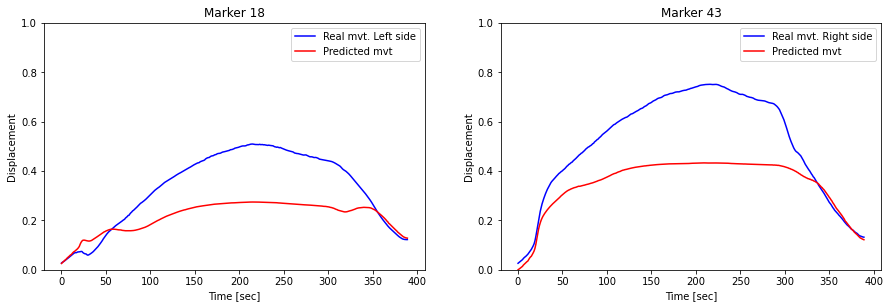

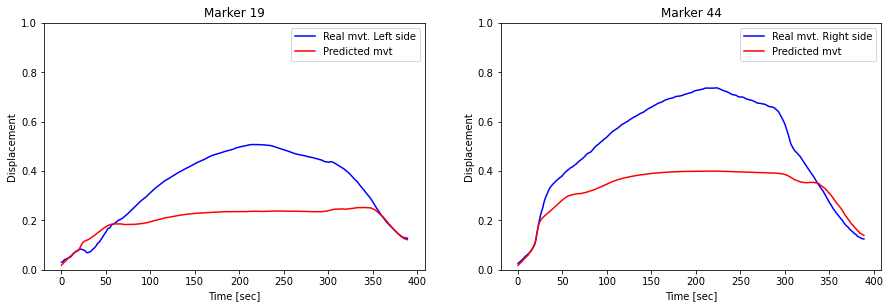

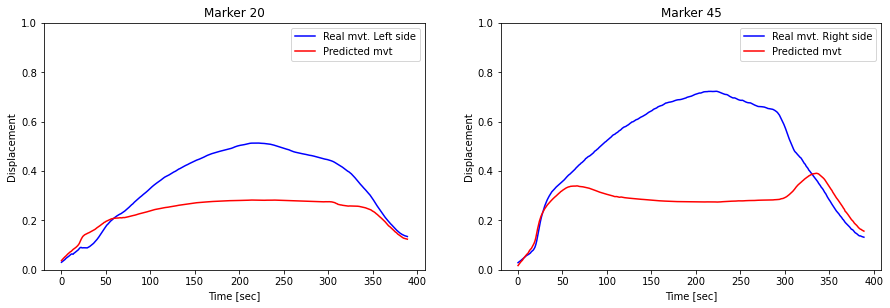

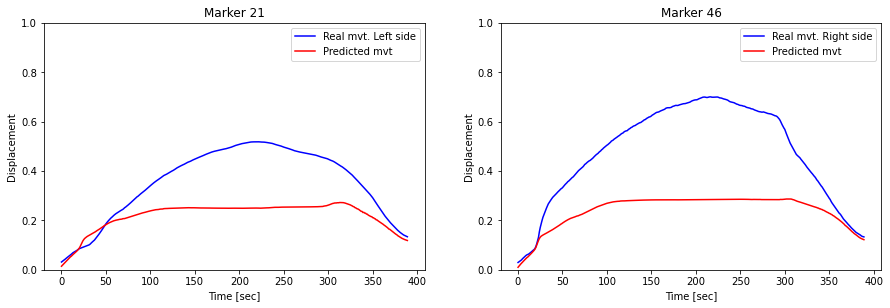

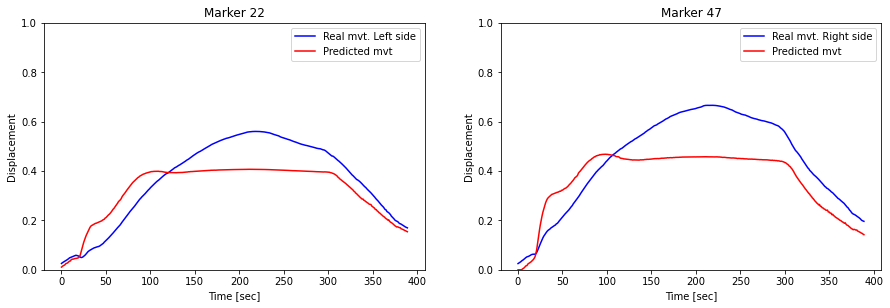

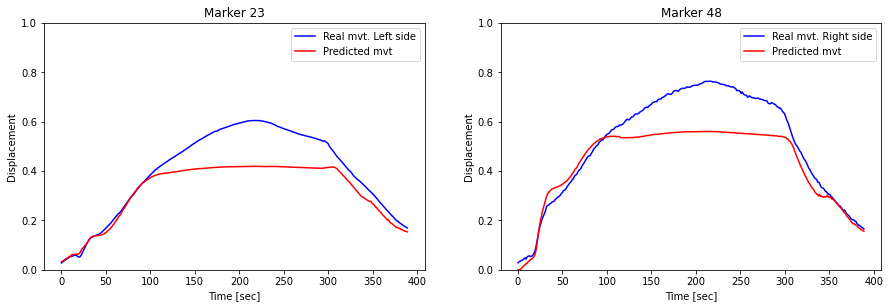

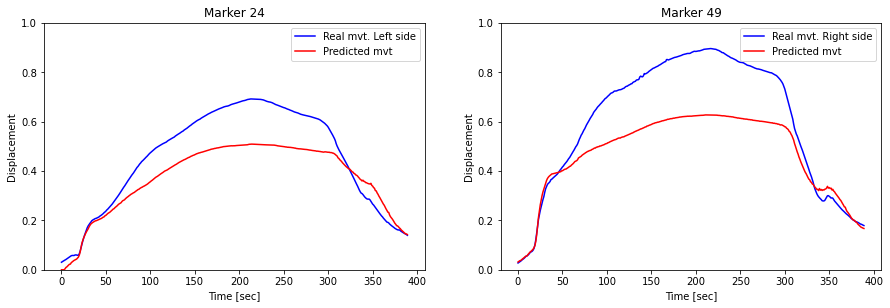

In [27]:
for x, y in dataset_test_p.take(1):
    for i in range(0,25):
        multi_step_plot(y,model_2.predict(x), i,i+25)

In [ ]:
# SAVE
#df_stat_g_p.to_excel('rmse_p_01_g.xlsx',header=None)
#df_stat_d_p.to_excel('rmse_p_01_d.xlsx',header=None)

#### Test en mm

In [28]:
## inverse scaled
y_list, pred_list = list(), list()
for x, Y in dataset_test_p:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat_p = functions.list_invers_scaled(pred_list, max_value_list_p, min_value = 0)
y_real_p = functions.list_invers_scaled(y_list, max_value_list_p, min_value = 0)

In [33]:
newDF_mm = rmse_mm(y_real_p, yhat_p)

In [34]:
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
mean_g ,mean_d,dif_rel

(4.1147730000000005, 4.9619626, 0.8471895999999992)